# Image Classification
In this tutorial we will be creating and training a neural network to classify images in the CIFAR10 dataset. This excercise will approximately follow Pytorch's [Training a Classifier Tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). We encourage you to complete this in Google Colab to make use of their GPU if you don't have personal access to one. If you choose to complete this in Colab, ensure your Runtime type is using a GPU. 

This notebook was created by Keaton Kraiger.

In [18]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision 
import torchvision.transforms as transforms

To process our images we create a `transform` to apply to the data. Of course we want our images to be `Tensors` and we can normalize them. If we wanted to perform data augmentation, placing the augmentation operation(s) in the transform can make processing images easier.
- Before `ToTensor` and `Normalize`, add the `RandAugment` transformation inside `transform` using `torchvision`. Feel free to try different parameters.

In [19]:
transform = transforms.Compose(
     ### START CODE HERE ### (≈ 1 lines of code)
     [transforms.RandAugment(),
     ### END CODE HERE ### 
     transforms.ToTensor(),  
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

Let us now create our dataset and dataloaders for training and testing.

In [20]:
batch_size= 8


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Files already downloaded and verified
Files already downloaded and verified


We can also quickly plot a few of the images from our dataset. It is generally a good idea to add as much visualization as you can. This not only helps you when trying to understand the program, but others who look at it.

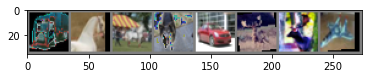

truck horse horse dog   car   deer  deer  plane


In [21]:
def imshow(img):
  img=img/2+0.5
  npimg=img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Define your network
We can now define our network we'll use to classify the images. Here we can follow PyTorch's example toy network. You may also make changes to it if you'd like. 

In [22]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Define a loss function and optimizer
Because we have multiple classes we will use cross-entropy for our loss. For our optimizer let's try the `Adam` algorithm. Initialize an `Adam` optimizer and assign it to `optimizer`. Feel free to try different parameters. 

In [23]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()

### START CODE HERE ### (≈ 1 lines of code)
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0001)
### END CODE HERE ###

## Training
Like our tutorial, we create a loop to train the network in for some number of epochs.

In [24]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.922
[1,  4000] loss: 1.713
[1,  6000] loss: 1.640
[2,  2000] loss: 1.568
[2,  4000] loss: 1.509
[2,  6000] loss: 1.489
Finished Training


In [25]:
# You can save the trained model if you'd like
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## Testing the network
We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

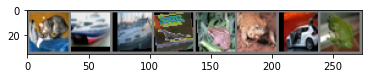

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog 


In [26]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

Now, let's pass the images through the "trained" network.

In [27]:
outputs = net(images.to(device))

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:

In [28]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(8)))

Predicted:  dog   car   car   car   cat   frog  cat   frog 


Of course, we also want to send the entire test or holdout set through our network to measure its performance.

In [29]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 48 %


It is also very useful to see what classes are performing well and those that are not.

In [30]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 58.2 %
Accuracy for class: car   is 63.1 %
Accuracy for class: bird  is 23.6 %
Accuracy for class: cat   is 31.8 %
Accuracy for class: deer  is 25.0 %
Accuracy for class: dog   is 46.6 %
Accuracy for class: frog  is 61.9 %
Accuracy for class: horse is 55.7 %
Accuracy for class: ship  is 45.9 %
Accuracy for class: truck is 64.9 %


## Pretrained network
Often when you are working with neural networks it will make sense to use existing, popular architectures which have already demonstrated good performance on the task you are interested in. 

Let's now try loading a pretrained network. Using torchvision, instantiate a `ResNet-18` with its weights already pretrained on ImageNet and assign the network to `resnet`.


In [31]:
### START CODE HERE ### (≈ 1 lines of code)
resnet = torchvision.models.resnet18(weights= torchvision.models.ResNet18_Weights.DEFAULT)
### END CODE HERE ###

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In this case, because our network is pretrained on ImageNet, the network is expecting 1000 classes. 

In [32]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

We can see the final layer `fc` has 1000 out_features, the number of ImageNet classes, and will not work for our CIFAR10 case. 

When finetuning pretrained networks, the case of freezing or not freezing the intermediate layers will differ depending on what you want to achieve, but we know the final layer needs to be re-trained. 

For this example, let's try keeping the pretrained ImageNet weights and adding a new final layer.
- Freeze all layers in `resnet` by setting their `requires_grad` to False.

In [33]:
### START CODE HERE ### (≈ 2 lines of code)
# for param in resnet.parameters():
#   param.requires_grad = False
# # # ### END CODE HERE ###

# # # # let's check all our layers are frozen
# for param in resnet.parameters():
#   assert param.requires_grad == False

# Freeze Code


Let's now update the final layers dimensions.
- set `resnet`'s final layer to a new `Linear` layer using `in_features` and our target output size.

In [34]:
in_features = resnet.fc.in_features

### START CODE HERE ### (≈ 2 lines of code)
resnet.fc = nn.Linear(in_features, 10)
### END CODE HERE ###

Now we are ready to train. Let's stick with Cross-Entropy for our criterion, but let us now try stochastic gradient descent for optimization.
-  Set the variable `optimizer` to a `SGD` optimizer with your choice of parameters. Be sure to give it our new network's parameters.
- make sure our network is sent to `device`

In [37]:
### START CODE HERE ### (≈ 2 lines of code)
optimizer = torch.optim.SGD(params=resnet.parameters(), lr=0.001, momentum=0.5, weight_decay=0.005)
resnet.to(device)
### END CODE HERE ###

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Once again we will train our network. Here I am only training for 5 epochs, but feel free to try training the network for longer.

In [38]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.699
[1,  4000] loss: 1.444
[1,  6000] loss: 1.330
[2,  2000] loss: 1.234
[2,  4000] loss: 1.178
[2,  6000] loss: 1.141
[3,  2000] loss: 1.096
[3,  4000] loss: 1.075
[3,  6000] loss: 1.043
[4,  2000] loss: 1.000
[4,  4000] loss: 0.987
[4,  6000] loss: 0.954
[5,  2000] loss: 0.941
[5,  4000] loss: 0.947
[5,  6000] loss: 0.911
Finished Training


Similarly we will test our performance. 
For grading : There is no fix test accuracy to get full marks. Experiment with different settings and submit the best accuracy you get

In [39]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = resnet(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 68 %


## Feature Visualization 
After training a network one may be interested in the features their network is learning. In our case these features will be from ImageNet but the idea remains the same.

One way to get a better understanding of these learned features is through visualizing your network's outputs at various intermediate layers. These outputs should differ depending on the layer's depth and may provide some us some insight . Let's take a look at the output of different convolutional filters in our ResNet.

Image of a cat!


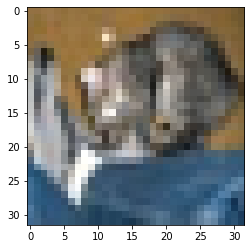

In [40]:
# Load an image to work with, it doesn't have to be from our dataset either
dataiter = iter(testloader)
images, labels = next(dataiter)

print(f"Image of a {classes[labels[0]]}!")
imshow(images[0])

Pytorch allows one to "extract" a network's individual layers, allowing us to pass our image through the layers seperately and examine the output.

Below we will make the list `layers` to hold the extracted `Conv2d` layers in `resnet`. Recall when we printed `resnet` and note the architecture of the ResNet model. The model is comprised of multiple basic blocks where each block has convolutional layers inside.
- We access the network's layers with pytorch's `children` function and store them in `layers`
- In the case of a sequential layer, let's create a `for` loop to iterate over each child. Looking at `resnet`'s architecture, we must also check the `children` of each sequential layer.
- create a `for` loop to iterate over ever layer in the current `child`, again using `children`.
- For each layer in the current child, check if the layer is a `Conv2d`
- if so, append it to `layers` and increment `count`.

In [41]:
layers = []

resnet_children = list(resnet.children())
count = 0

# Let's get all Conv layers in the network
for child in resnet_children:
  if type(child) == nn.Conv2d:
    layers.append(child)
    count+=1
  elif type(child) == nn.Sequential:
    for i in range(len(child)):
      ### START CODE HERE ### (≈ 4 lines of code)
      for subchild in child[i].children():
        if type(subchild)== nn.Conv2d:
          layers.append(subchild)
          count +=1
      ### END CODE HERE ###


print(f"Extracted {count} layers.")
for layer in layers:
  assert type(layer) == nn.Conv2d

Extracted 17 layers.


Now that we have all the convolutional layers in our ResNet, we can pass our example image through each one individually.
- Create a `for` loop to send `image` through each of layer in `layers`
- append the output to the `outputs` list.

In [42]:
image = images[0]
image = image.unsqueeze(0) # We add another dim (where batch size would be) so the layers will accept the image
image = image.to(device)

outputs = []

# Below we pass image through each layer seperately, you can pass
# image through a layer exactly as you would in a regular network

### START CODE HERE ### (≈ 3 lines of code)
for layer in layers:
    image = layer(image)
    outputs.append(image)
### END CODE HERE ###

assert len(outputs) == len(layers)

Process the layer outputs.

In [43]:
filtered_images = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    filtered_images.append(gray_scale.data.cpu().numpy())

Finally we can print the different filtered images obtained from the layers of our network. Notice how the outputs change at different layers in the network. 

Also, the earlier images may be a little blurrier than one would expect. This is mostly because the images start off at such a low fidelity.

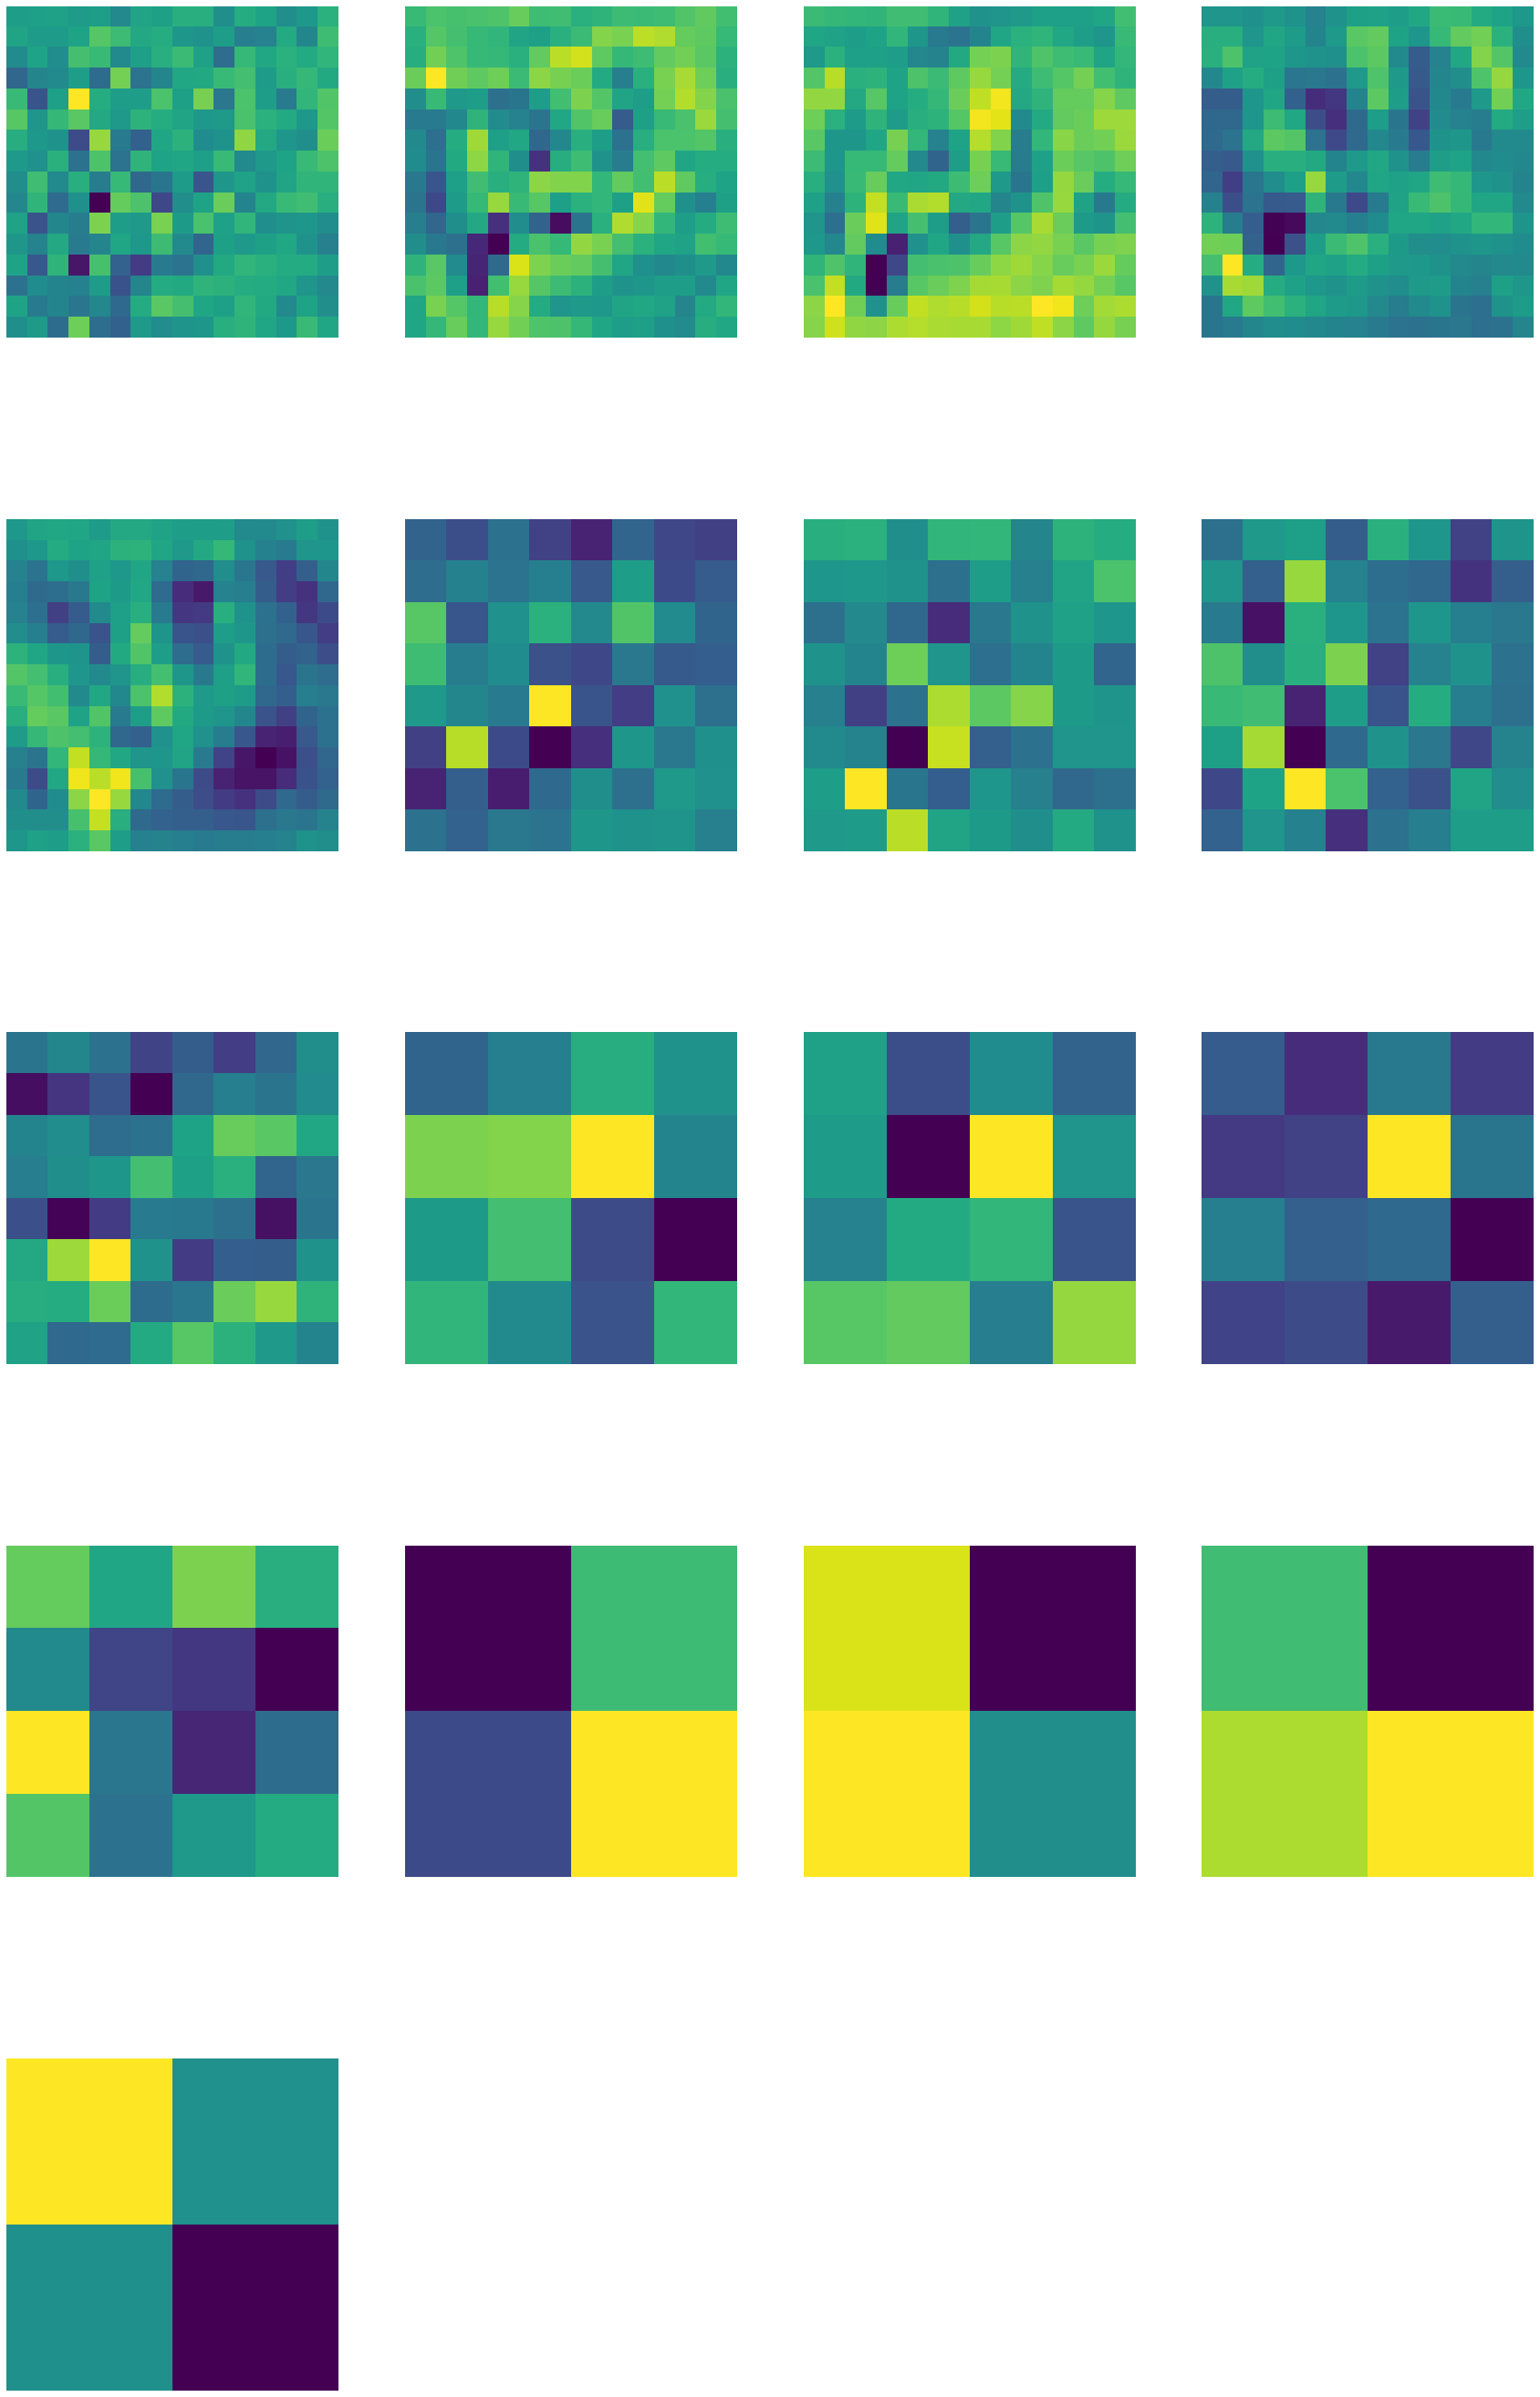

In [44]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(filtered_images)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(filtered_images[i])
    a.axis("off")